In [0]:
from google.colab import files
files.upload()

In [12]:
!ls -lha kaggle.json
!pip install -q kaggle


-rw-r--r-- 1 root root 67 Sep 21 18:34 kaggle.json


In [0]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:10<00:00, 137MB/s]
100% 1.15G/1.15G [00:10<00:00, 113MB/s]


In [18]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
!unzip chest_xray.zip

Library imports. Resource: https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning/blob/master/code/Detection%20of%20Pneumonia%20from%20Chest%20X-Ray%20Images%201.0.0.3.ipynb

In [0]:


import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


# from keras import backend as K
# K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
input_directory = "/content/chest_xray"
training_dir = input_directory + r"/train"
validation_dir = input_directory + r"/val"
testing_dir = input_directory + r"/test"

Image preprocessing and Augmentation.
https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [0]:
rescale = 1./255
train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=rescale)

test_datagen = ImageDataGenerator(rescale=rescale)


In [39]:
train_generator = train_datagen.flow_from_directory(
    directory=training_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 5216 images belonging to 2 classes.


In [40]:
valid_generator = valid_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 16 images belonging to 2 classes.


In [94]:
test_generator = test_datagen.flow_from_directory(
    directory=testing_dir,
    target_size=(150,150),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 624 images belonging to 2 classes.


Customizing the model(InceptionV3)

In [0]:

#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    
#     x = Dropout(0.5)(x)
    
#     x = GlobalAveragePooling2D()(x)
    
#     x = Dense(512, activation='relu')(x)
#     # x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    x = Flatten()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
        
    
#     model.summary()
        

Model compiliation.

In [0]:
# steps_per_epoch=len(train_generator)
# validation_steps=len(valid_generator)


optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100


model.compile(optimizer, loss=loss, metrics=metrics)

Model fitting and training.

In [55]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)


# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch = steps_per_epoch,
#     epochs=epochs,
#     verbose=2,
#     validation_data=valid_generator,
#     validation_steps=len(valid_generator))

Epoch 1/10
163/163 [==============================] - 337s 2s/step - loss: 0.5313 - acc: 0.9208 - val_loss: 3.8235 - val_acc: 0.7500
Epoch 2/10
163/163 [==============================] - 336s 2s/step - loss: 0.5311 - acc: 0.9247 - val_loss: 5.2275 - val_acc: 0.5625
Epoch 3/10
163/163 [==============================] - 336s 2s/step - loss: 0.5901 - acc: 0.9220 - val_loss: 6.4842 - val_acc: 0.5000
Epoch 4/10
163/163 [==============================] - 334s 2s/step - loss: 0.5151 - acc: 0.9296 - val_loss: 6.8405 - val_acc: 0.5625
Epoch 5/10
163/163 [==============================] - 336s 2s/step - loss: 0.5334 - acc: 0.9256 - val_loss: 6.7539 - val_acc: 0.5625
Epoch 6/10
163/163 [==============================] - 339s 2s/step - loss: 0.5499 - acc: 0.9237 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/10
163/163 [==============================] - 338s 2s/step - loss: 0.5612 - acc: 0.9260 - val_loss: 5.6902 - val_acc: 0.5000
Epoch 8/10
163/163 [==============================] - 338s 2s/step - 

Model evaluation. (Treating validation set as test data set for evaluation)

In [88]:
result = model.evaluate_generator(generator=valid_generator,
steps=len(valid_generator))

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

Loss     : 3.91  
Accuracy : 75.00%


In [0]:
# just for testing

print("train",train_generator.classes,"test",test_generator.classes)

Prediction and output.

In [91]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
y_pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

print(y_pred)

624/624 [==============================] - 58s 93ms/step
[1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0
 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0
 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0
 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 

In [96]:
result1 = model.evaluate_generator(generator=test_generator,
steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result1[0]))
print("%s%.2f%s"% ("Accuracy : ", result1[1]*100, "%"))


624/624 [==============================] - 62s 99ms/step
Loss     : 2.97  
Accuracy : 75.80%


Visualization.

In [169]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 237
-----------------------------------
Batch Size              : 1
-----------------------------------
Accuracy                : 75.80%
-----------------------------------


In [105]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params
  


figure_directory created


In [116]:
!mkdir -p /content/figure_directory
print("figure_directory created")
figure_directory = "/content/figure_directory"
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

class_map = {v: k for k, v in test_generator.class_indices.items()}


dpi=100


ncols = 8
# ncols = batch_size_t if batch_size_t<ncols else ncols     
# nrows = batch_size_t/ncols
# nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)
nrows = 4

count = ncols*nrows


subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

figure_directory created


In [0]:
def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
  
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0,length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread('/content/chest_xray/test/'+ file_names[num], 1)
        plt.imshow(img)
        
        
#     DEBUGGING
#         img = cv2.imread('/content/chest_xray/test/NORMAL/IM-0003-0001.jpeg')
#         plt.imshow(img)
#         img = cv2.imread('/content/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg')
#         plt.imshow(img)
        
#         print('here image',img)
        
        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
            

#         if plot_params["update_image"] and os.path.exists(image_file_name):
#             os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()
    
    

In [0]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_batch, count=count, sample=True)

KeyboardInterrupt: ignored

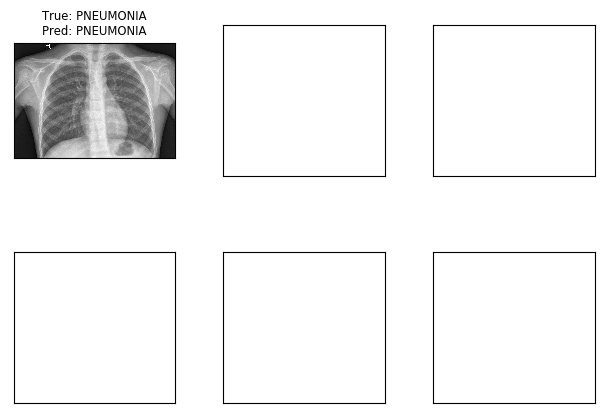

In [196]:
ncols = 3
nrows = 2

if batch_size_t<3:
    cols = 1
    
count = cols*nrows
    

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()


show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_sample, count=count, sample=True)

In [0]:
# Debugging

img = cv2.imread('/content/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg')
# print(img)
plt.imshow(img)

In [0]:
# debugging

print(y_true)
print(y_pred)